# Document classification

## XGBoost

Gabriel Ziegler

## Data

Tagged by lawyers on challenger

|column|value|
|------|-----|
|document_id|Document id in database|
|first_page|Only the text content of first page for each document|
|label|Label of especialists|

Dump date:

* 27-06-2018
* 26-06-2018

Dataset's proportions:

* 70% train
* 20% validation
* 10% test

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy as sp
import numpy as np
import paramiko
import os, sys
import multiprocessing
import tensorflow as tf
import joblib

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, precision_score,
    recall_score, precision_recall_fscore_support, f1_score
)

from nltk.corpus import stopwords
from scipy.special import comb

from tqdm import tqdm

import xgboost as xgb
from xgboost import XGBClassifier

from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Dataset
## Loading

In [4]:
sys.path.append('../../../db/')
sys.path.append('../../../helpers/')
from commit import connect

query_result = connect()

In [52]:
# import json from NAS
host = "hehet.lades.unb.br"
port = 22
transport = paramiko.Transport((host, port))

password="L@desehet"
username="hehet"
transport.connect(username=username, password=password)
sftp = paramiko.SFTPClient.from_transport(transport)

In [53]:
path_train='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/01-08-2018/train-01-08-2018-wo-duplicates.csv'
file_csv = sftp.file(path_train)
train = pd.read_csv(file_csv, usecols=['label', 'first_page', 'pages', ])

path_test='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/01-08-2018/test-01-08-2018-wo-duplicates.csv'
file_csv = sftp.file(path_test)
test = pd.read_csv(file_csv, usecols=['label', 'first_page', 'pages', ])

path_validation='/mnt/lvm/lvm_array2/lvm101_GPAM/Pecas/01-08-2018/validation-01-08-2018-wo-duplicates.csv'
file_csv = sftp.file(path_validation)
validation = pd.read_csv(file_csv, usecols=['label', 'first_page', 'pages', ])

train.head()

,label,pages,first_page
0,ARE,"[{'index': 0, 'body': '(e-STJ Fl.278)\n DEFENS...",(e-STJ Fl.278)\n DEFENSORIA PÚBLICA DA UNIÃO N...
1,ARE,"[{'index': 0, 'body': "" \n \n \n\n \n\n(e-S...",\n \n \n\n \n\n(e-STJ FI.248)i!3\n\n3H\n\n...
2,ARE,"[{'index': 0, 'body': '2009.71.55.001920-7 Pre...",2009.71.55.001920-7 Presidência da 2ª Turma Re...
3,ARE,"[{'index': 0, 'body': '1\nEXCELENTÍSSIMO (A) S...",1\nEXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JU...
4,ARE,"[{'index': 0, 'body': '2009.71.58.011511-9 Pre...",2009.71.58.011511-9 Presidência da 2ª Turma Re...


In [54]:
train = train[(train.label != 'D. Agrav') & (train.label != 'P. Agrav')]
test = test[(test.label != 'D. Agrav') & (test.label != 'P. Agrav')]
validation = validation[(validation.label != 'D. Agrav') & (validation.label != 'P. Agrav')]

labels_index = train.label.value_counts().index.sort_values()

label_train = train.label.value_counts()[labels_index]
label_validation = validation.label.value_counts()[labels_index]
label_test = test.label.value_counts()[labels_index]
labels = (test.label.value_counts() + validation.label.value_counts() + train.label.value_counts())[labels_index]
print("Train")
print(label_train[labels_index])
print("\nValidation")
print(label_validation[labels_index])
print("\nTeste")
print(label_test[labels_index])
print("\nTotal")
print(labels)
print("\nCount: ", labels.sum())

Train
ARE         640
Acordão     573
Desp.       388
Outro      1961
RE          440
Sent.       767
Name: label, dtype: int64

Validation
ARE        183
Acordão    164
Desp.      111
Outro      561
RE         125
Sent.      219
Name: label, dtype: int64

Teste
ARE         92
Acordão     82
Desp.       55
Outro      280
RE          63
Sent.      110
Name: label, dtype: int64

Total
ARE         915
Acordão     819
Desp.       554
Outro      2802
RE          628
Sent.      1096
Name: label, dtype: int64

Count:  6814


# Visually see document text corpus

In [67]:
train.iloc[0].pages

'[{\'index\': 0, \'body\': \'(e-STJ Fl.278)\\n DEFENSORIA PÚBLICA DA UNIÃO N O R I O\\n D E J A N E I R O\\n TRF2\\n Paj: 2014/016-16082\\n Fls 278\\n EXMO. SR. DR. DESEMBARGADOR FEDERAL PRESIDENTE DO EGRÉGIO\\n TRIBUNAL REGIONAL FEDERAL DA 2ª REGIÃO\\n Processo nº 0008510-56.2011.4.02.5001\\n Objeto: Agravo contra Negativa de Seguimento de Recurso Extraordinário\\n Documento No: 73257-88-0-278-9-822389 - consulta à autenticidade do documento através do site http://portal.trf2.jus.br/autenticidade\\n CRISTIANO REIS SIQUEIRA, devidamente qualificado nos presentes\\n autos, assistida pela DEFENSORIA PÚBLICA DA UNIÃO, vem, no prazo em dobro\\n contado de sua intimação pessoal com vista dos autos (art. 44, inciso I, da Lei\\n Protocolada por Flávio Luiz Marques Penna Marinho em 11/05/2016 17:31:42. (Processo: 0008510-56.2011.4.02.5001 - Petição: 2016.6000.039672-4) .\\n Complementar nº 80/94, com redação dada pela Lei Complementar nº 132/2009),\\n apresentar, na forma do artigo 1042 do Cód

# Pre processing

In [71]:
from pre_processing.pre_processing import BatchProcessing

pre_processing_pipe = [
    str.lower, 'clean_email', 'clean_site', 'clean_document',
    'transform_token', 'remove_letter_number', 'clean_number',
    'remove_small_big_words', 'clean_spaces'
]

clean_train = BatchProcessing.parallel_processing(pre_processing_pipe, [str(doc) for doc in train.pages], progress=True)

100%|██████████| 4769/4769 [00:09<00:00, 515.77it/s]


In [74]:
clean_validation = BatchProcessing.parallel_processing(pre_processing_pipe, [str(doc) for doc in validation.pages], progress=True)
clean_test = BatchProcessing.parallel_processing(pre_processing_pipe, [str(doc) for doc in test.pages], progress=True)

100%|██████████| 682/682 [00:00<00:00, 746.01it/s] 


In [75]:
train.pages = clean_train
validation.pages = clean_validation
test.pages = clean_test

train.head()

,label,pages,first_page
0,ARE,index body stj n defensoria pública união o i ...,(e-STJ Fl.278)\n DEFENSORIA PÚBLICA DA UNIÃO N...
1,ARE,index body n n n e stj niran amaral advogados ...,\n \n \n\n \n\n(e-STJ FI.248)i!3\n\n3H\n\n...
2,ARE,index body presidência turma recursal dos jefs...,2009.71.55.001920-7 Presidência da 2ª Turma Re...
3,ARE,index body nexcelentíssimo a senhor a doutor a...,1\nEXCELENTÍSSIMO (A) SENHOR (A) DOUTOR (A) JU...
4,ARE,index body presidência turma recursal dos jefs...,2009.71.58.011511-9 Presidência da 2ª Turma Re...


## Chi words

In [68]:
# chi_words = pd.read_csv('Chi2.csv', index_col=0)
# chi_top_words = chi_words['0'][:int(chi_words.size * 0.3)].tolist()

# def chi_filter(x):
#     words = x.split(' ')
#     chi_words = [y for y in words if y in chi_top_words]
#     return ' '.join(chi_words)
    
# train['text'] = [chi_filter(x) for x in tqdm(train['text'])]
# validation['text'] = [chi_filter(x) for x in tqdm(validation['text'])]
# test['text'] = [chi_filter(x) for x in tqdm(test['text'])]

# train = train[train.text.str.len() > 0]
# validation = validation[validation.text.str.len() > 0]
# test = test[test.text.str.len() > 0]

# TFiDF Vectorization

In [85]:
tfidf = TfidfVectorizer()

X_train = tfidf.fit_transform(train.pages)
X_validation = tfidf.transform(validation.pages)
X_test = tfidf.transform(test.pages)

X_train.shape, X_validation.shape, X_test.shape

((4769, 122829), (1363, 122829), (682, 122829))

# Label Encoding

In [123]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le_train = le.fit_transform(train['label'])
le_test = le.transform(test['label'])

le_train

array([0, 0, 0, ..., 5, 5, 5])

# XGBoost

In [ ]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=le_train)
dtest = xgb.DMatrix(X_test, label=le_test)

# Multiclass params

In [172]:
param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': Y_train.shape[1]
}

num_round = 15  # the number of training iterations

# Training

In [173]:
bst = xgb.train(param, dtrain, num_round)

# Checking performance on test set

In [174]:
preds = bst.predict(dtest)

In [175]:
le_test[:5]
preds[:5]

array([3, 0, 1, 0, 3])

array([3., 0., 0., 0., 3.], dtype=float32)

In [176]:
print(classification_report(le.inverse_transform(le_test), le.inverse_transform(preds.astype(int)), target_names=le.classes_))

             precision    recall  f1-score   support

        ARE       0.96      0.96      0.96        92
    Acordão       0.86      0.89      0.87        82
      Desp.       0.96      0.78      0.86        55
      Outro       0.92      0.92      0.92       280
         RE       0.95      0.98      0.97        63
      Sent.       0.94      0.98      0.96       110

avg / total       0.93      0.93      0.93       682



/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Confusion Matrix

In [177]:
cm = confusion_matrix(le.inverse_transform(le_test), le.inverse_transform(preds.astype(int)), labels=le.classes_)
cm

/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 88,   1,   0,   2,   1,   0],
       [  1,  73,   0,   5,   1,   2],
       [  0,   0,  43,  12,   0,   0],
       [  3,  11,   2, 258,   1,   5],
       [  0,   0,   0,   1,  62,   0],
       [  0,   0,   0,   2,   0, 108]])

In [178]:
def plot_confusion_matrix(cm, classes, normalized=True, cmap='bone'):
    plt.figure(figsize=[24, 16])
    norm_cm = cm
    if normalized:
        norm_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(norm_cm, annot=cm, fmt='g', xticklabels=classes, yticklabels=classes, cmap=cmap)

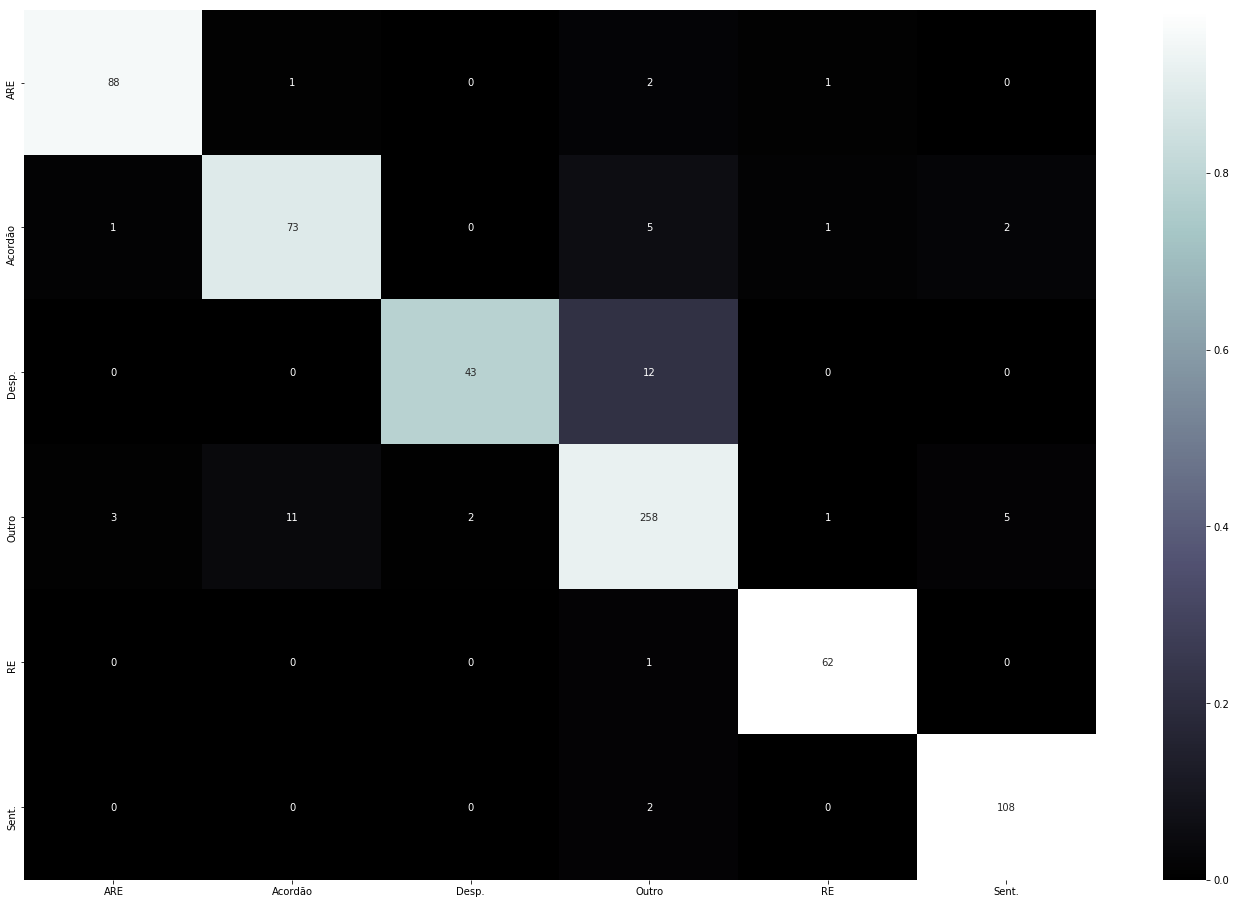

In [179]:
plot_confusion_matrix(cm, le.classes_)

# Concat train and validation set

In [150]:
trainval = pd.concat([train, validation])
trainval.shape

(6132, 3)

In [160]:
X_trainval = tfidf.fit_transform(trainval.pages)
X_test_ = tfidf.transform(test.pages)

le_trainval = le.fit_transform(trainval.label)
le_test_ = le.fit_transform(test.label)

dtrainval = xgb.DMatrix(X_trainval, label=le_trainval)
dtest_ = xgb.DMatrix(X_test_, label=le_test_)

# Train model with larger train dataset

In [157]:
bst_big = xgb.train(param, dtrainval, num_round)

In [161]:
big_pred = bst_big.predict(dtest_)

# Evaluate new model

In [162]:
print(classification_report(le.inverse_transform(le_test_), le.inverse_transform(big_pred.astype(int)), target_names=le.classes_))

             precision    recall  f1-score   support

        ARE       0.95      0.97      0.96        92
    Acordão       0.88      0.90      0.89        82
      Desp.       0.96      0.80      0.87        55
      Outro       0.94      0.93      0.93       280
         RE       0.95      0.98      0.97        63
      Sent.       0.94      0.99      0.96       110

avg / total       0.93      0.93      0.93       682



/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [163]:
cm_big = confusion_matrix(le.inverse_transform(le_test_), le.inverse_transform(preds.astype(int)), labels=le.classes_)
cm_big

/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/seth/env/ml_service/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([[ 89,   0,   0,   2,   1,   0],
       [  1,  74,   0,   4,   1,   2],
       [  0,   0,  45,  10,   0,   0],
       [  3,  12,   2, 257,   1,   5],
       [  0,   0,   0,   1,  62,   0],
       [  0,   0,   0,   2,   0, 108]])

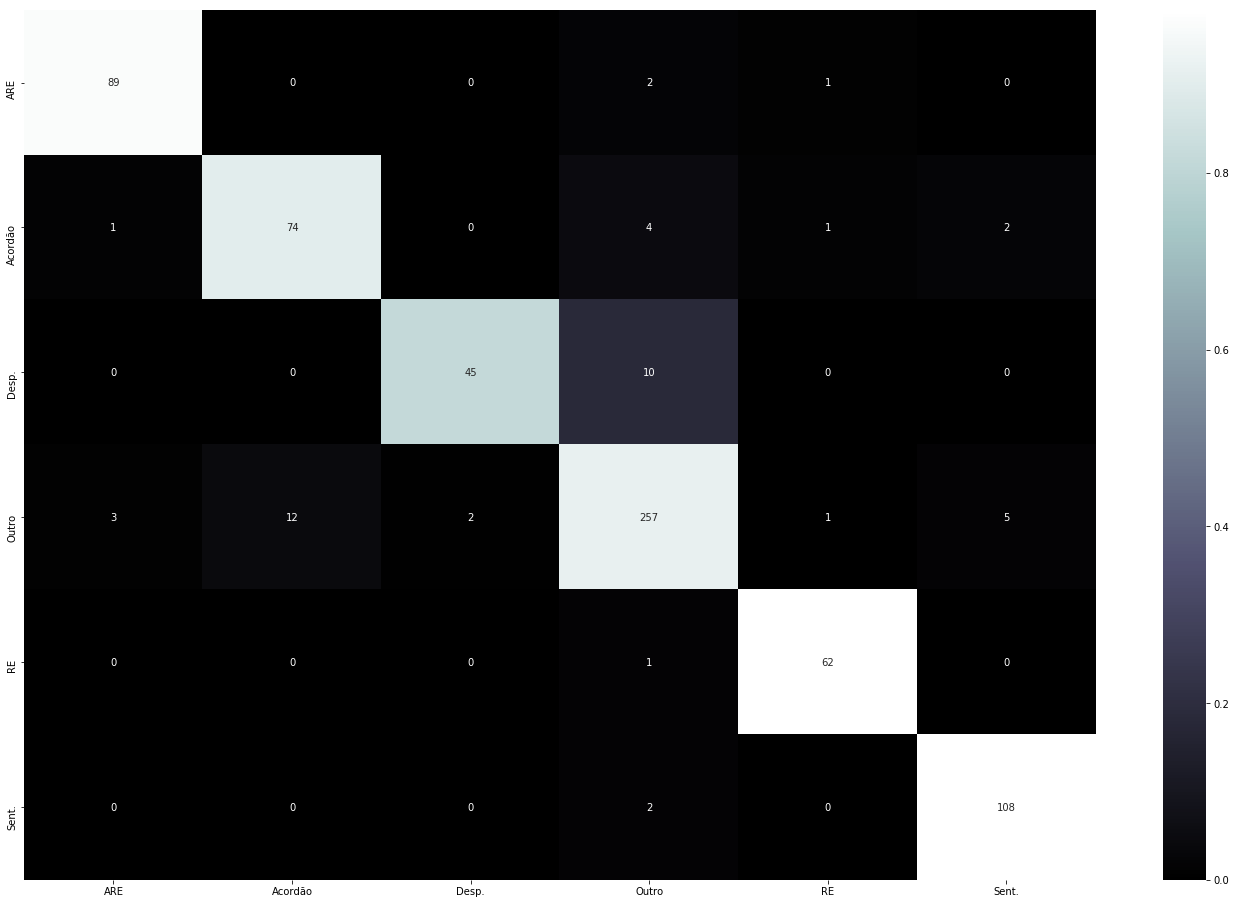

In [164]:
plot_confusion_matrix(cm_big, le.classes_)